# Datathon 3.0 
### Forecasting of Dengue cases in Singapore


In [1]:
#Standard data preprocessing imports
import os

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (16.0, 10)

First step of any data science/machine learning project is to conduct Exploratory Data Analysis (EDA) to see if there are any inherent structures or patterns in the data. This is even more important in time-series data to see if the patterns observed are cyclical, seasonal or if there are any trends within the data. For this analysis we are provided with 4 columns of data:

- Dengue Cases (Weekly Data)
- Rainfall (Daily - Geographical)
- Temperature (Daily - Geographical)
- Population (Yearly Data)


In this first section we will look at post-2012 data and see if we can find any patterns in the data, independent of the other data provided. This will include the data preprocessing and visualisation steps.

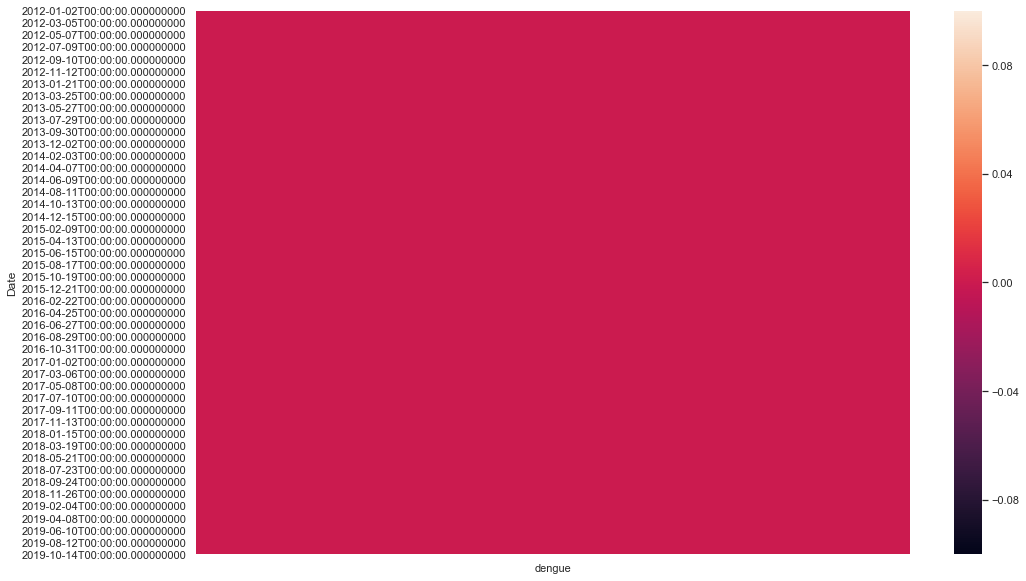

In [4]:
#Loading the Data
post2012 = []
for i in range(2012,2020):
    df = pd.read_csv("dengue-post2012/" + str(i)+ ".csv")
    df["Epidemiology Wk"]= df["Epidemiology Wk"].apply(lambda x: str(i)+ "-" + f'{x:02}') #Label Week Column with the year
    post2012.append(df)
post2012 = pd.concat(post2012) #Combine dataframes into 1 
#Converting the string to a Datetime object starting on Monday and then changing the index
post2012["Date"] = pd.to_datetime(post2012["Epidemiology Wk"] + str(1) ,format = "%Y-%W%w" )
post2012.drop("Epidemiology Wk",axis = 1,inplace = True)
post2012.set_index("Date",inplace = True)
post2012.head()

With the preprocessing step complete, we can proceed to visualise the data and identify any trends present within the data

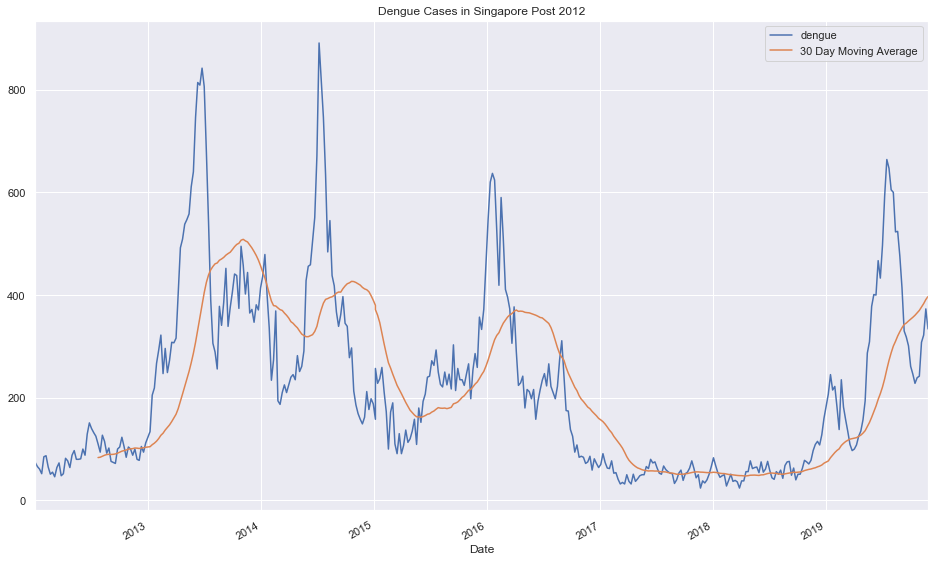

In [5]:
post2012.plot(legend = True, label = 'Dengue Cases',title = 'Dengue Cases in Singapore Post 2012')
post2012.rolling(window = 30).mean()["dengue"].plot(label = "30 Day Moving Average", legend = True)

From the graph shown, it seems that dengue cases usually undergo sharp spikes of around 3-4 months in length and take around the same time to reduce back to its original value. This data is largely consistent with dengue being a contagious disease that can be prone to outbreaks. There seems to be an overall decline in dengue cases however to fully explain the data we have to look at the poulation and meteorological data provided

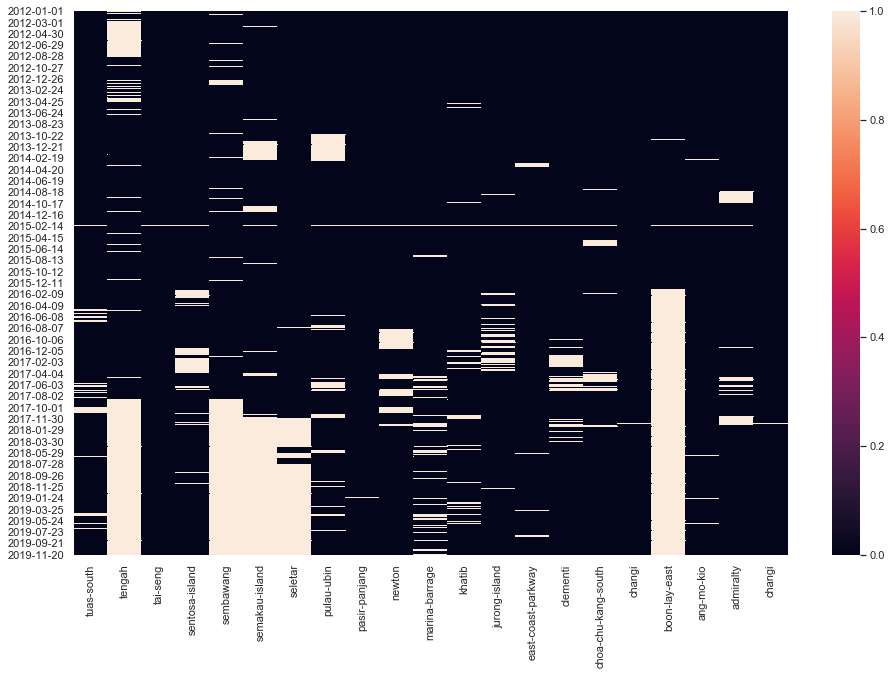

In [7]:
#Processing of Temperature Data
import os 

temps = pd.read_csv("temperature/changi") # Changi Chosen because it has the most data 
temps["date"] = temps.apply(lambda x:'{0}-{1:02}-{2:02}'.format(int(x['year']),int(x["month"]),int(x["day"])),axis=1)
temps = temps.drop(["year","month","day"],axis=1)
temps.set_index("date",inplace = True)
temps.rename(columns = {"Mean Temperature (&#176;C)":"changi"},inplace = True)

for file in os.listdir("temperature/"):
    df = pd.read_csv("temperature/" + file)
    df["date"] = df.apply(lambda x:'{0}-{1:02}-{2:02}'.format(int(x['year']),int(x["month"]),int(x["day"])),axis=1)
    df = df.drop(["year","month","day"],axis=1)
    df.set_index("date",inplace = True)
    df.rename(columns = {"Mean Temperature (&#176;C)": file},inplace = True)
    temps = pd.concat([df,temps],axis = 1,sort = True)


#Since only training the model from 2012 onwards, only temperature from 2012
temps = temps.loc["2012-01-01":]
sns.heatmap(temps.isnull())

The meteorological data provided to us is divided into regions however the dengue cases are not, as such we choose to aggregate the data into a single column "Singapore Temperature" to reduce dimensionality and should allow the model to generalise better. As can be seen from the heatmap, some locations have many missing values and these columns are dropped before aggregating. The data is also converted to weekly data after since the target variable is also weekly.

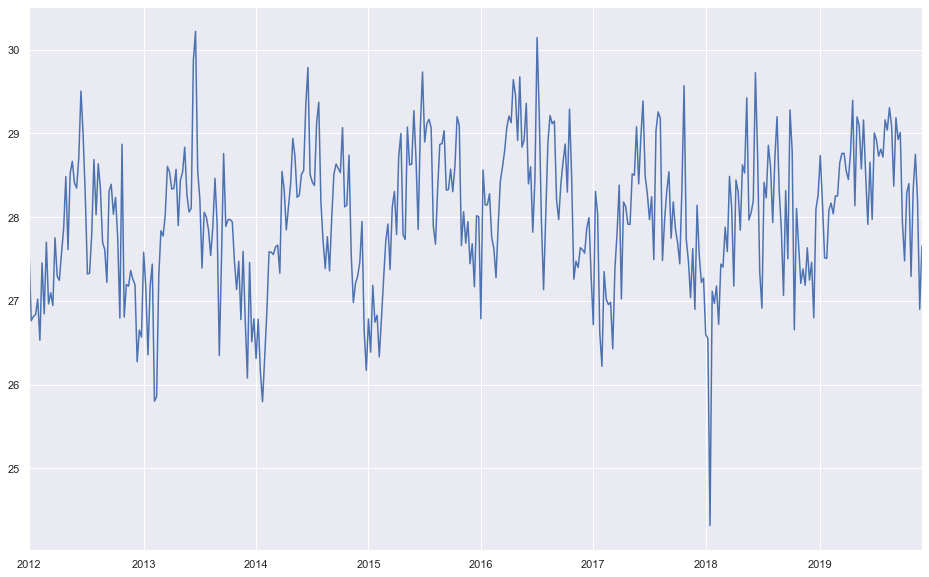

In [8]:
temps.drop(["tengah","sembawang","semakau-island","boon-lay-east","seletar"],axis = 1, inplace= True)
temps["Avg Temp"] = temps.apply(np.mean,axis = 1)
temps = temps["Avg Temp"]
temps.index = pd.to_datetime(temps.index, format = "%Y-%m-%d") #Convert Index to a Datetime Object so that weekly resampling can be done
temps = temps.resample(rule = "W-Mon").mean()
temps.plot()

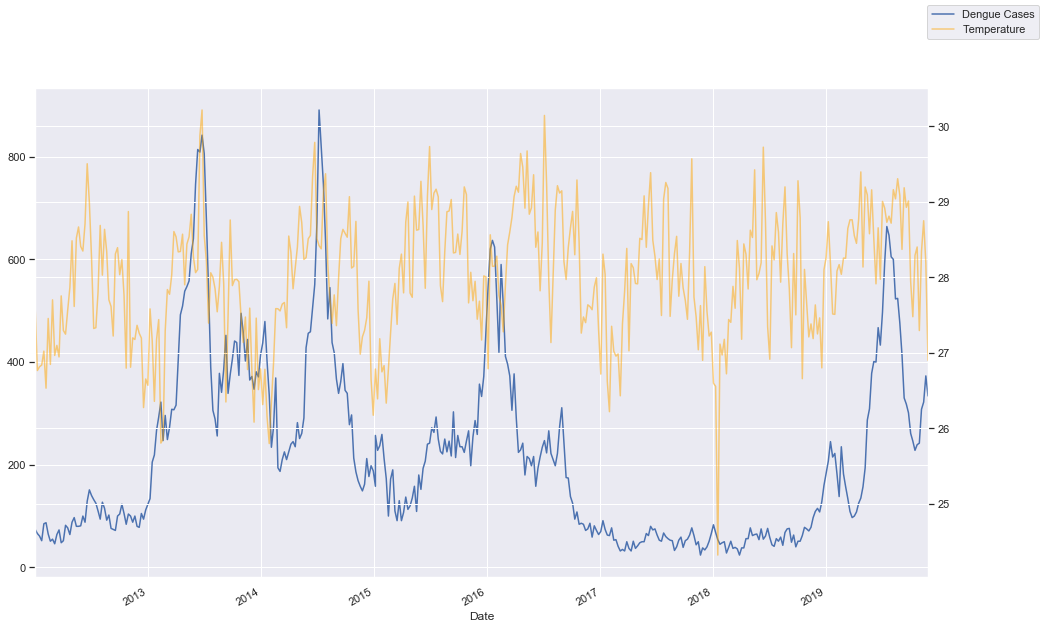

In [17]:
#Plotting Graph of Temperature with Dengue Cases 
ax = post2012.plot(y = "dengue", label = "Dengue Cases", legend = False)
ax2 = ax.twinx()
ax2.plot(temps,color = "orange",alpha = 0.5,label = "Temperature")
ax.figure.legend()


As can be seen from the graph shown, there is little correlation between the 2 plots however, temperature data can help improve the effectiveness of the model slightly. From research, the Aedes mosquito is most active at 28 Degrees and less active at lower temperatures. This can explain some of the differences in the data but not completely. As a result we need to add in rainfall data to see if it can explain the remainding variance from the data. 

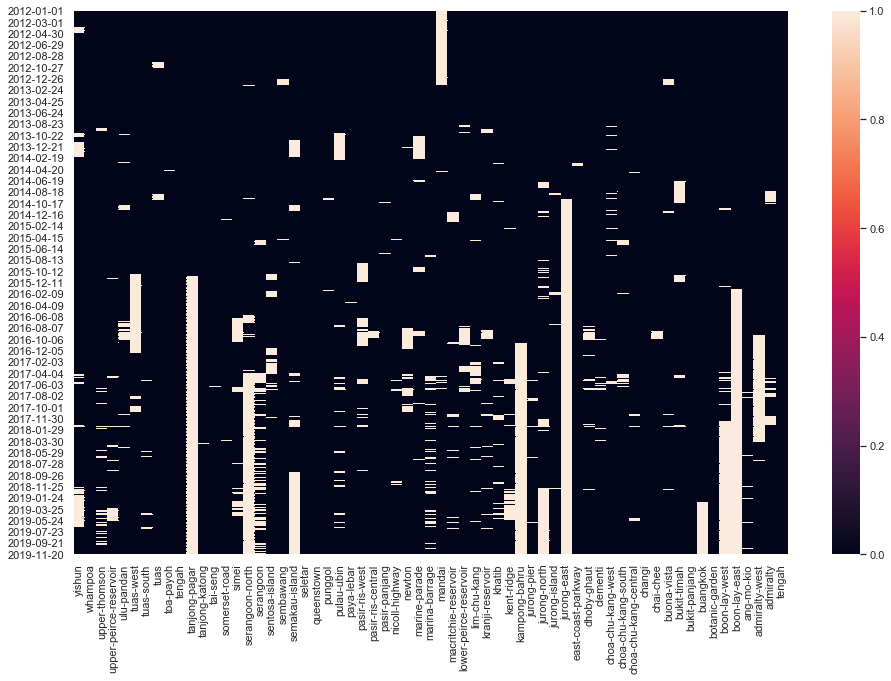

In [18]:
#Preprocessing of Rainfall Data

rain = pd.read_csv("rainfall/tengah") # Tengah Chosen because it has the most data 
rain["date"] = rain.apply(lambda x:'{0}-{1:02}-{2:02}'.format(int(x['year']),int(x["month"]),int(x["day"])),axis=1)
rain = rain.drop(["year","month","day"],axis=1)
rain.set_index("date",inplace = True)
rain.rename(columns = {"Daily Rainfall Total (mm)":"tengah"},inplace = True)

for file in os.listdir("rainfall/"):
    df = pd.read_csv("rainfall/" + file)
    df["date"] = df.apply(lambda x:'{0}-{1:02}-{2:02}'.format(int(x['year']),int(x["month"]),int(x["day"])),axis=1)
    df = df.drop(["year","month","day"],axis=1)
    df.set_index("date",inplace = True)
    df.rename(columns = {"Daily Rainfall Total (mm)": file},inplace = True)
    rain = pd.concat([df,rain],axis = 1,sort = True)


#Since only training the model from 2012 onwards, only temperature from 2012
rain = rain.loc["2012-01-01":]
sns.heatmap(rain.isnull())

Similar to the temperature data there is a signficant number of missing values. Here instead of dropping areas which do no thave enough data point, we choose to fill it with that row average. This is a reasonable enough assumption since Singapore is relatively small and the rainfall experienced across the different regions should not differ by much. 

In [23]:
rainT = rain.T.fillna(value = rain.mean(axis = 1), axis =0)
rain = rainT.T
#Resampling to get weekly 
rain.index = pd.to_datetime(rain.index, format = "%Y-%m-%d") #Convert Index to a Datetime Object so that weekly resampling can be done
rain = rain.resample(rule = "W-Mon").mean()
rain["Average Rain"] = rain.mean(axis = 1)

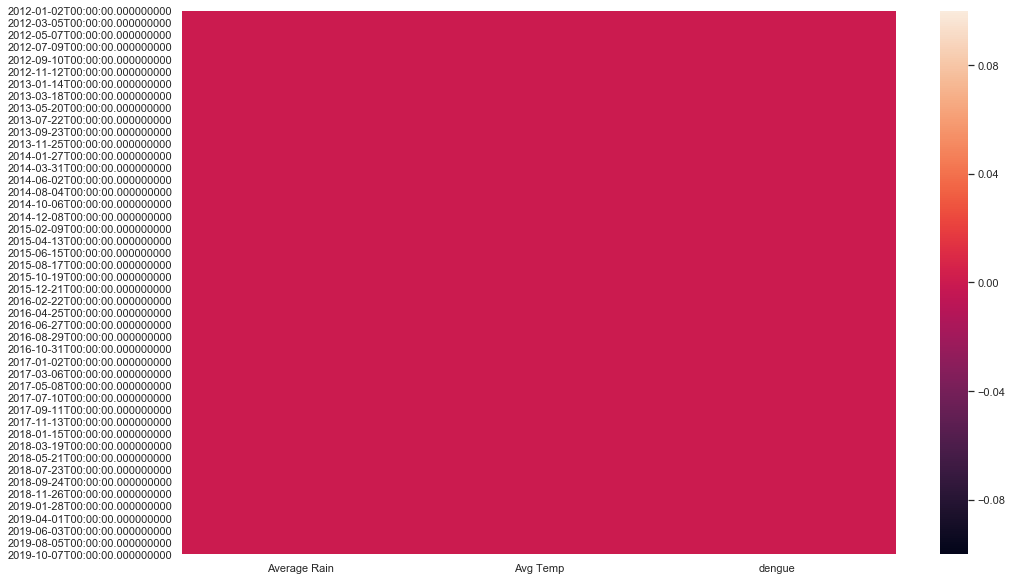

In [46]:
processed = pd.DataFrame([rain["Average Rain"],temps])
processed = processed.T
processed = processed.iloc[:-1,:]
resample = post2012.resample("W-Mon").mean()
processed = pd.concat([processed,resample],sort = True,axis =1)
processed.fillna(method = "bfill",inplace = True)
sns.heatmap(processed.isnull())